In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import seaborn as sns
import time
#import winsound
import lightgbm as lgb
import xgboost as xgb
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, log_loss, brier_score_loss
from sklearn.ensemble import RandomForestClassifier
import lightgbm
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

In [12]:
submit_prediction = True
validate = False
XGB = False
LGBM = True

In [13]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")


In [14]:
df_train

,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,0,21,female,b.sc,7.91,98.8,no,4.9,average,online videos,low,easy,78.300
1,1,18,other,diploma,4.95,94.8,yes,4.7,poor,self-study,medium,moderate,46.700
2,2,20,female,b.sc,4.68,92.6,yes,5.8,poor,coaching,high,moderate,99.000
3,3,19,male,b.sc,2.00,49.5,yes,8.3,average,group study,high,moderate,63.900
4,4,23,male,bca,7.65,86.9,yes,9.6,good,self-study,high,easy,100.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
629995,629995,18,female,b.tech,4.86,70.7,yes,4.1,good,mixed,high,moderate,69.500
629996,629996,21,female,ba,7.08,54.4,yes,4.5,average,mixed,low,moderate,78.900
629997,629997,24,male,bca,0.64,44.2,yes,4.3,poor,online videos,low,moderate,19.599
629998,629998,20,male,b.com,1.54,75.1,yes,8.2,average,group study,high,moderate,59.100


In [15]:
# find missing values
missing_values = df_train.isnull().sum()
missing_values = missing_values[missing_values > 0]

if not missing_values.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=missing_values.index, y=missing_values.values, palette='viridis')
    plt.xticks(rotation=90)
    plt.xlabel('Features')
    plt.ylabel('Missing Values')
    plt.title('Missing Values per Feature')
    plt.tight_layout()
    plt.show()
else:
    print("✅ No missing values found in the dataset.")

✅ No missing values found in the dataset.


In [16]:
#implementation of new features

diff_value_map = {"easy": 1, "moderate": 2, "hard": 3}

df_train["difficulty_score"] = (
    df_train["exam_difficulty"]
    .astype(str)
    .str.strip()
    .str.lower()
    .map(diff_value_map)
)


df_train["study_hours_per_age"] = df_train["study_hours"] / df_train["age"]
df_train["effective_study"] = df_train["study_hours"] * df_train["class_attendance"] / 100
df_train["difficulty_adjusted_study"] = df_train["study_hours"] / df_train["difficulty_score"]
df_train["attendance_vs_difficulty"] = df_train["class_attendance"] / df_train["difficulty_score"]




#DF_TEST

df_test["difficulty_score"] = (
    df_test["exam_difficulty"]
    .astype(str)
    .str.strip()
    .str.lower()
    .map(diff_value_map)
)

df_test["study_hours_per_age"] = df_test["study_hours"] / df_test["age"]
df_test["effective_study"] = df_test["study_hours"] * df_test["class_attendance"] / 100
df_test["difficulty_adjusted_study"] = df_test["study_hours"] / df_test["difficulty_score"]
df_test["attendance_vs_difficulty"] = df_test["class_attendance"] / df_test["difficulty_score"]



if 'id' in df_train.columns:
    df_train = df_train.drop(columns=['id'])
if 'id' in df_test.columns:
    df_test = df_test.drop(columns=['id'])

df_test = df_test.drop(["internet_access"], axis=1)
df_train = df_train.drop(["internet_access"], axis=1)
df_test = df_test.drop(["exam_difficulty"], axis=1)
df_train = df_train.drop(["exam_difficulty"], axis=1)
df_test = df_test.drop(["difficulty_score"], axis=1)
df_train = df_train.drop(["difficulty_score"], axis=1)
df_test = df_test.drop(["course"], axis=1)
df_train = df_train.drop(["course"], axis=1)

In [17]:
df_train

,age,gender,study_hours,class_attendance,sleep_hours,sleep_quality,study_method,facility_rating,exam_score,study_hours_per_age,effective_study,difficulty_adjusted_study,attendance_vs_difficulty
0,21,female,7.91,98.8,4.9,average,online videos,low,78.300,0.376667,7.81508,7.910,98.80
1,18,other,4.95,94.8,4.7,poor,self-study,medium,46.700,0.275000,4.69260,2.475,47.40
2,20,female,4.68,92.6,5.8,poor,coaching,high,99.000,0.234000,4.33368,2.340,46.30
3,19,male,2.00,49.5,8.3,average,group study,high,63.900,0.105263,0.99000,1.000,24.75
4,23,male,7.65,86.9,9.6,good,self-study,high,100.000,0.332609,6.64785,7.650,86.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...
629995,18,female,4.86,70.7,4.1,good,mixed,high,69.500,0.270000,3.43602,2.430,35.35
629996,21,female,7.08,54.4,4.5,average,mixed,low,78.900,0.337143,3.85152,3.540,27.20
629997,24,male,0.64,44.2,4.3,poor,online videos,low,19.599,0.026667,0.28288,0.320,22.10
629998,20,male,1.54,75.1,8.2,average,group study,high,59.100,0.077000,1.15654,0.770,37.55


In [18]:
#Train data
categorical_columns = df_train.select_dtypes(include=['object']).columns.tolist()
encoder = OneHotEncoder(sparse_output=False)

one_hot_encoded = encoder.fit_transform(df_train[categorical_columns])

one_hot_df_train = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))

df_train_encoded = pd.concat([df_train, one_hot_df_train], axis=1)

df_train_encoded = df_train_encoded.drop(categorical_columns, axis=1)


#Test data
categorical_columns = df_test.select_dtypes(include=['object']).columns.tolist()
encoder = OneHotEncoder(sparse_output=False)

one_hot_encoded = encoder.fit_transform(df_test[categorical_columns])

one_hot_df_test = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))

df_test_encoded = pd.concat([df_test, one_hot_df_test], axis=1)

df_test_encoded = df_test_encoded.drop(categorical_columns, axis=1)


print(f"Encoded Train data : \n{df_train_encoded}")
print(f"Encoded Test data : \n{df_test_encoded}")

Encoded Train data : 
        age  study_hours  class_attendance  sleep_hours  exam_score  \
0        21         7.91              98.8          4.9      78.300   
1        18         4.95              94.8          4.7      46.700   
2        20         4.68              92.6          5.8      99.000   
3        19         2.00              49.5          8.3      63.900   
4        23         7.65              86.9          9.6     100.000   
...     ...          ...               ...          ...         ...   
629995   18         4.86              70.7          4.1      69.500   
629996   21         7.08              54.4          4.5      78.900   
629997   24         0.64              44.2          4.3      19.599   
629998   20         1.54              75.1          8.2      59.100   
629999   18         3.94              75.3          5.8      37.200   

        study_hours_per_age  effective_study  difficulty_adjusted_study  \
0                  0.376667          7.81508      

In [19]:
X = df_train_encoded.drop(columns=["exam_score"])  # remove target from traings data
y = df_train_encoded["exam_score"]

In [20]:
from sklearn.model_selection import KFold

def validate_model_regression(
    X_training, y,
    n_estimators=500, learning_rate=0.05, num_leaves=31, max_depth=-1,
    min_child_samples=20, subsample=0.8, colsample_bytree=0.8,
    reg_alpha=0.0, reg_lambda=0.0
):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    oof_preds = np.zeros(len(y), dtype=float)

    for fold, (tr_idx, val_idx) in enumerate(kf.split(X_training), start=1):
        X_tr, X_val = X_training.iloc[tr_idx], X_training.iloc[val_idx]
        y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]  # y is a Series

        m = lgb.LGBMRegressor(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            num_leaves=num_leaves,
            max_depth=max_depth,
            min_child_samples=min_child_samples,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            random_state=42 + fold,
            n_jobs=-1,
        )

        m.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], eval_metric="rmse")
        oof_preds[val_idx] = m.predict(X_val)

        rmse = np.sqrt(mean_squared_error(y, oof_preds))
        mae = mean_absolute_error(y, oof_preds)
        r2 = r2_score(y, oof_preds)
        return rmse, mae, r2


if validate:
    rmse, mae, r2 = validate_model_regression(
    X_training=X,
    y=df_train["exam_score"],
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8
)

print("RMSE:", rmse)
print("MAE:", mae)
print("R2:", r2)



NameError: name 'rmse' is not defined

In [21]:
seeds = [i for i in range(6)]
models = []

if XGB and submit_prediction:
    for s in seeds:
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.2, random_state=s
        )
        X_tr, X_val, y_tr, y_val = train_test_split(
            X_train, y_train, test_size=0.2, random_state=s
        )

        model = xgb.XGBRegressor(
            objective="reg:squarederror",
            n_estimators=5000,
            learning_rate=0.03,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.0,
            reg_lambda=1.0,
            random_state=42,
            tree_method="hist",   # fast on CPU
            n_jobs=-1
)

        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=100
        )

        models.append(model)

In [22]:
seeds = [i for i in range(6)]
models = []



if LGBM and submit_prediction:
    kwargs = {
        "n_estimators": 5000,
        "learning_rate": 0.05,
        "max_depth": -1,          # often better than forcing 6
        "subsample": 0.8,
        "colsample_bytree": 0.8,  # 0.2 can be too restrictive
        "random_state": 42,
        "n_jobs": -1,
        "objective": "regression",
    }

    for s in seeds:
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.2, random_state=s
        )
        # No inner split needed unless you want a separate holdout
        model = lgb.LGBMRegressor(**kwargs)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric="rmse",
            callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)]
        )
        models.append(model)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 504000, number of used features: 22
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 62.488538
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1616
[LightGBM] [Info] Number of data points in the train set: 504000, number of used features: 2

In [23]:
# --- Print Averaged Feature Importances ---
if models:  # Only if models were trained
    print("\n=== Averaged Feature Importances (Across All Models) ===")

    # Collect importances from each model (default: 'split' count)
    importances_list = [model.feature_importances_ for model in models]

    # Average them
    avg_importances = np.mean(importances_list, axis=0)

    # Create sorted DataFrame (assumes X is a pandas DataFrame with column names)
    imp_df = pd.DataFrame({
        'feature': X.columns,
        'importance': avg_importances
    }).sort_values(by='importance', ascending=False).reset_index(drop=True)

    # Print top 20 (adjust as needed)
    print(imp_df.head(20))

    # Optional: Save to CSV
    imp_df.to_csv("feature_importances.csv", index=False)
    print("\nFeature importances saved to 'feature_importances.csv'")
else:
    print("No models were trained.")


=== Averaged Feature Importances (Across All Models) ===
                       feature   importance
0             class_attendance  9606.333333
1                  sleep_hours  8490.666667
2                  study_hours  8345.666667
3              effective_study  6338.333333
4          study_hours_per_age  6260.666667
5     attendance_vs_difficulty  5725.666667
6    difficulty_adjusted_study  5333.500000
7                          age  2811.000000
8           sleep_quality_poor  1265.666667
9        study_method_coaching  1265.166667
10        facility_rating_high  1179.500000
11          sleep_quality_good  1155.000000
12         facility_rating_low  1150.833333
13     study_method_self-study   870.333333
14          study_method_mixed   824.000000
15               gender_female   779.000000
16                 gender_male   769.833333
17                gender_other   755.833333
18       sleep_quality_average   744.000000
19  study_method_online videos   719.833333

Feature importanc

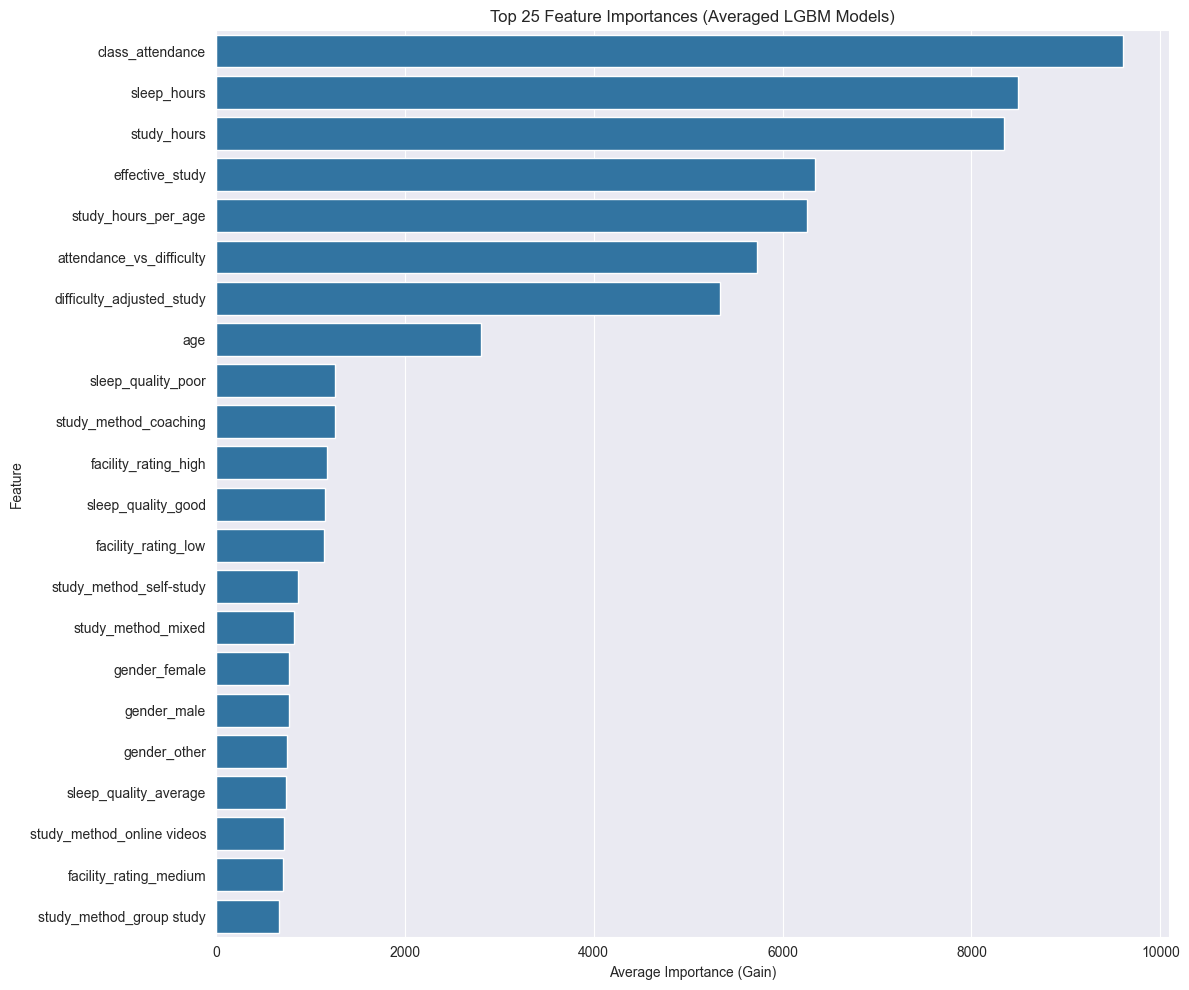

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=imp_df.head(25))
plt.title('Top 25 Feature Importances (Averaged LGBM Models)')
plt.xlabel('Average Importance (Gain)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [25]:
if submit_prediction:
    preds = []
    for model in models:
        bi = getattr(model, "best_iteration", None)
        if bi is not None:
            preds.append(model.predict(df_test_encoded, num_iterations=bi))
        else:
            preds.append(model.predict(df_test_encoded))

    preds_arr = np.vstack(preds)
    mean_pred = preds_arr.mean(axis=0)

In [26]:
df_test = pd.read_csv("test.csv")
#submission file
submission = pd.DataFrame({
    "id": df_test["id"],
    "exam_score": mean_pred
})

submission.to_csv("submission.csv", index=False)

print("submission.csv created")

submission.csv created
